In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
from matplotlib_venn import venn2
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [3]:
train_df = pd.read_csv('/content/drive/My Drive/youtube_compe/data/train_data.csv')
test_df = pd.read_csv('/content/drive/My Drive/youtube_compe/data/test_data.csv')

In [4]:
train_y = train_df['y']
del train_df["y"]

In [5]:
df = pd.concat([train_df, test_df])

### preprocessing

In [6]:
# channelId
le_channelId = LabelEncoder()
df['channelId'] = le_channelId.fit_transform(df['channelId'])

In [7]:
# drop id , video_id  and thumbnail_link
del df['id']
del df['video_id']
del df['thumbnail_link']

In [8]:
# publishedAt
df["publishedAt"] = pd.to_datetime(df["publishedAt"])
df["year"] = df["publishedAt"].dt.year
df["month"] = df["publishedAt"].dt.month
df["day"] = df["publishedAt"].dt.day
df["hour"] = df["publishedAt"].dt.hour
df["minute"] = df["publishedAt"].dt.minute
del df["publishedAt"]

In [9]:
# collection_date
df["collection_date"] = "20" + df["collection_date"]
df["collection_date"] = pd.to_datetime(df["collection_date"], format="%Y.%d.%m")
df["c_year"] = df["collection_date"].dt.year
df["c_month"] = df["collection_date"].dt.month
df["c_day"] = df["collection_date"].dt.day
del df["collection_date"]

In [10]:
# evaluation
df['evaluation'] = df['likes'] + df['dislikes']

In [11]:
# 言語処理はあとで行う
df = df.drop(["title","channelTitle","tags","description"], axis=1)

In [12]:
df.head(2)

,channelId,categoryId,likes,dislikes,comment_count,comments_disabled,ratings_disabled,year,month,day,hour,minute,c_year,c_month,c_day,evaluation
0,7498,20,114,0,7,False,False,2011,1,9,5,50,2020,2,1,114
1,12289,10,2885,50,111,False,False,2012,7,23,3,0,2020,2,8,2935


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49302 entries, 0 to 29581
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   channelId          49302 non-null  int64
 1   categoryId         49302 non-null  int64
 2   likes              49302 non-null  int64
 3   dislikes           49302 non-null  int64
 4   comment_count      49302 non-null  int64
 5   comments_disabled  49302 non-null  bool 
 6   ratings_disabled   49302 non-null  bool 
 7   year               49302 non-null  int64
 8   month              49302 non-null  int64
 9   day                49302 non-null  int64
 10  hour               49302 non-null  int64
 11  minute             49302 non-null  int64
 12  c_year             49302 non-null  int64
 13  c_month            49302 non-null  int64
 14  c_day              49302 non-null  int64
 15  evaluation         49302 non-null  int64
dtypes: bool(2), int64(14)
memory usage: 5.7 MB


In [14]:
# データの分割
train = df.iloc[:len(train_y), :]
test = df.iloc[len(train_y):, :]

In [32]:
# kfold
cv = KFold(n_splits=5, shuffle=True, random_state=20)
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 20,
    'learning_rate': 0.01,
    "n_jobs": -1,
    "verbose": -1
}

In [33]:
y = np.log(train_y)

In [34]:
pred =0
score = 0

###  training

In [35]:
for tr_idx, val_idx in cv.split(train):
    x_train, x_val = train.iloc[tr_idx], train.iloc[val_idx]
    y_train, y_val = y[tr_idx], y[val_idx]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_train, y_train)
    val_set = lgb.Dataset(x_val, y_val, reference=train_set)
        
    # Training
    model = lgb.train(params, train_set, num_boost_round=2000, early_stopping_rounds=500,
                      valid_sets=[train_set, val_set], verbose_eval=500)
    
    # 予測したらexpで元に戻す
    test_pred = np.exp(model.predict(test))
    # 0より小さな値があるとエラーになるので補正
    test_pred = np.where(test_pred < 0, 0, test_pred)
    pred += test_pred / 5  #  5fold回すので

    oof = np.exp(model.predict(x_val))
    oof = np.where(oof < 0, 0, oof)
    rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), oof))
    print(f"RMSLE : {rmsle}")
    score += model.best_score["valid_1"]["rmse"] / 5

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.789969	valid_1's rmse: 0.852919
[1000]	training's rmse: 0.72405	valid_1's rmse: 0.837867
[1500]	training's rmse: 0.671954	valid_1's rmse: 0.83344
[2000]	training's rmse: 0.63492	valid_1's rmse: 0.829974
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.63492	valid_1's rmse: 0.829974
RMSLE : 0.8291092871115427
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.78772	valid_1's rmse: 0.868292
[1000]	training's rmse: 0.717238	valid_1's rmse: 0.851734
[1500]	training's rmse: 0.672897	valid_1's rmse: 0.846488
[2000]	training's rmse: 0.636243	valid_1's rmse: 0.842501
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.636243	valid_1's rmse: 0.842501
RMSLE : 0.8420643386082884
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.791867	valid_1's rmse: 0.859406
[1000]	training's rmse: 0.72460

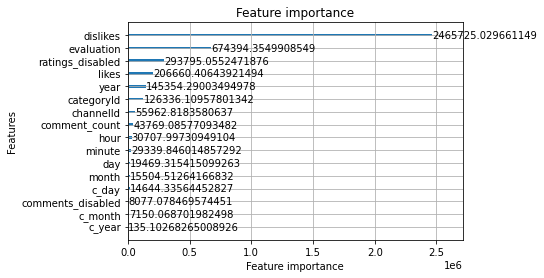

In [36]:
lgb.plot_importance(model, importance_type="gain", max_num_features=20)

In [37]:
print(f"Mean RMSLE SCORE :{score}")

Mean RMSLE SCORE :0.8407787879585761


In [39]:
submit_df = pd.DataFrame({"y": pred})
submit_df.index.name = "id"
submit_df.to_csv("submit.csv")

In [41]:
from google.colab import files
files.download('submit.csv')